# Set5

[Set5](https://people.rennes.inria.fr/Aline.Roumy/results/SR_BMVC12.html) 数据来源：[mmagic](https://mmagic.readthedocs.io/zh-cn/latest/dataset_zoo/div2k.html)/[Set5](https://drive.google.com/drive/folders/1B3DJGQKB6eNdwuQIhdskA64qUuVKLZ9u)



Set5数据集由 Marco Bevilacqua 等人的 [基于非负邻域嵌入的低复杂度单图像超分辨率](https://doi.org/10.5244/C.26.135) 引入的，它包含5张图像（“婴儿”、“鸟”、“蝴蝶”、“头部”、“女人”）的数据集，通常用于测试图像超分辨率模型的性能。

为了更方便地使用，本项目将其放置到 `tests/data/Set5`：

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
# 关闭交互模式
plt.ioff()
from set_env import root_dir

data_dir = root_dir/"tests/data/Set5"

项目根目录：/media/pc/data/lxw/ai/torch-book


In [2]:
for p in (data_dir/"GTmod12").iterdir():
    print(p.name)

baby.png
head.png
bird.png
butterfly.png
woman.png


可视化：

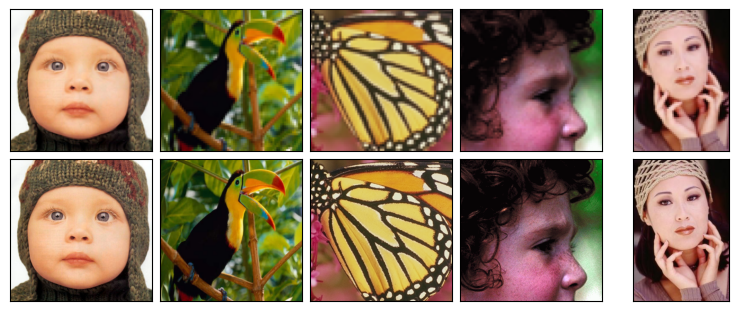

In [3]:
from PIL import Image
from torch_book.data.cv.plot import CompareGridFrame

imgs_names = sorted((data_dir/"LRbicx4").iterdir())
gt_names = sorted((data_dir/"GTmod12").iterdir())
grid = CompareGridFrame(1, 5, layout="row")
imgs = [Image.open(p) for p in imgs_names]
gts = [Image.open(p) for p in gt_names]
grid(imgs, gts)
grid.figure

## 构建数据集

In [4]:
from dataclasses import dataclass
from typing import Callable
from pathlib import Path
from torch.utils.data.dataset import Dataset
from torchvision import tv_tensors

@dataclass
class PairedDataset(Dataset):
    """成对图片数据集"""
    scale: int # 放大倍数, 2, 3, 4
    HR_path: str | Path # HR zip 数据路径
    LR_path: str | Path  # LR zip 数据路径
    transform: Callable | None = None

    def __post_init__(self):
        self.HR_path = Path(self.HR_path)
        self.LR_path = Path(self.LR_path)
        self.lr_names = sorted(self.LR_path.iterdir())
        self.hr_names = sorted(self.HR_path.iterdir())
        self._check()
    
    def _check(self):
        """检查图片对是否匹配"""
        assert len(self.lr_names) == len(self.hr_names)
        for a, b in zip(self.lr_names, self.hr_names):
            assert Path(a).name == Path(b).name, f"文件名 {a} 和 {b} 不匹配"

    def __len__(self) -> int:
        """返回数据集长度"""
        return len(self.lr_names)

    def __getitem__(self, index: int) -> list[tv_tensors.Image, tv_tensors.Image]:
        """加载(LR, HR)图片对

        Args:
            index: 图片的索引
        Returns:
            buffer: 图片的二进制内容
        """
        with Image.open(self.lr_names[index]) as im:
            lr = tv_tensors.Image(im)
        
        with Image.open(self.hr_names[index]) as im:
            hr = tv_tensors.Image(im)
        if self.transform is not None:
            lr, hr = self.transform(lr, hr)
        return lr, hr

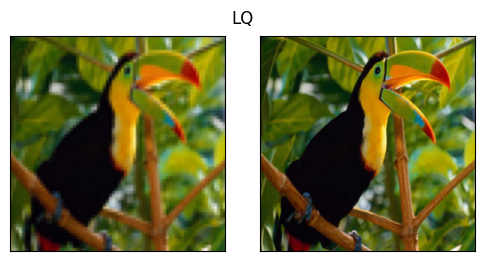

In [ ]:
import torch
from torch.utils.data.dataloader import DataLoader

scale = 4 # 放大倍数, 2, 3, 4
dataset = PairedDataset(
    scale,
    data_dir/"GTmod12",
    data_dir/f"LRbicx{scale}",
    transform=None
)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

with torch.no_grad():
    for lr, hr in data_loader:
        break
    canvas = CompareGridFrame(1, 1, 2.5)
    left_axes, right_axes = canvas(lr.permute(0, 2, 3, 1), hr.permute(0, 2, 3, 1))
    canvas.figure.suptitle("LQ")
    plt.close()
canvas.figure